Importamos las librerías necesarias

In [337]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [338]:
!pip install opendatasets
import opendatasets as od

Descargamos el dataset que se usará

In [339]:
ds_link = "https://www.kaggle.com/datasets/sunnykusawa/ecommerce-products-image-dataset"
od.download(ds_link)

Skipping, found downloaded files in "./ecommerce-products-image-dataset" (use force=True to force download)


Inspeccionamos el dataset, mirando cuántas imagenes hay por cada carpeta (clase)

In [340]:
import os

def contar_archivos_en_carpetas(ruta_carpeta):
  for root, dirs, files in os.walk(ruta_carpeta):
    print(f"Carpeta: {root}")
    print(f"Número de archivos: {len(files)}")
    print("-" * 20)  # Separador visual

# Define la ruta a la carpeta principal
data_dir = '/content/ecommerce-products-image-dataset/ecommerce products'  # Reemplaza con la ruta real

# Llama a la función para contar y mostrar archivos por carpeta
contar_archivos_en_carpetas(data_dir)


Carpeta: /content/ecommerce-products-image-dataset/ecommerce products
Número de archivos: 0
--------------------
Carpeta: /content/ecommerce-products-image-dataset/ecommerce products/sofa
Número de archivos: 199
--------------------
Carpeta: /content/ecommerce-products-image-dataset/ecommerce products/jeans
Número de archivos: 199
--------------------
Carpeta: /content/ecommerce-products-image-dataset/ecommerce products/tshirt
Número de archivos: 199
--------------------
Carpeta: /content/ecommerce-products-image-dataset/ecommerce products/tv
Número de archivos: 199
--------------------


Cargamos los datos en memoria, les hacemos un preprocesamiento basado en reducir el tamaño de todas las imágenes a la misma dimensión, además de normalizarlas, y los dividimos entre train, test y val

In [341]:
def preprocess_image(img_path, img_size):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img) / 255.0
    return img_array

In [342]:
def load_and_split_data(data_dir, classes, img_size, test_size=0.15, val_size=0.15):
    images = []
    labels = []

    for idx, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img_array = preprocess_image(img_path, img_size)  # Usar la función de preprocesamiento
            images.append(img_array)
            labels.append(idx)  # Asignar un índice a cada clase

    # Convertir a arrays de numpy
    images = np.array(images)
    labels = np.array(labels)

    # Dividir los datos en conjuntos de entrenamiento, validación y prueba
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=test_size, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, random_state=42)

    # Convertir etiquetas a one-hot encoding
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(classes))
    y_val = tf.keras.utils.to_categorical(y_val, num_classes=len(classes))
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=len(classes))

    return X_train, X_val, X_test, y_train, y_val, y_test

In [343]:
classes = ['jeans', 'sofa', 'tshirt', 'tv']
img_size = (128, 128)  # Tamaño de las imágenes
X_train, X_val, X_test, y_train, y_val, y_test = load_and_split_data(data_dir, classes, img_size)

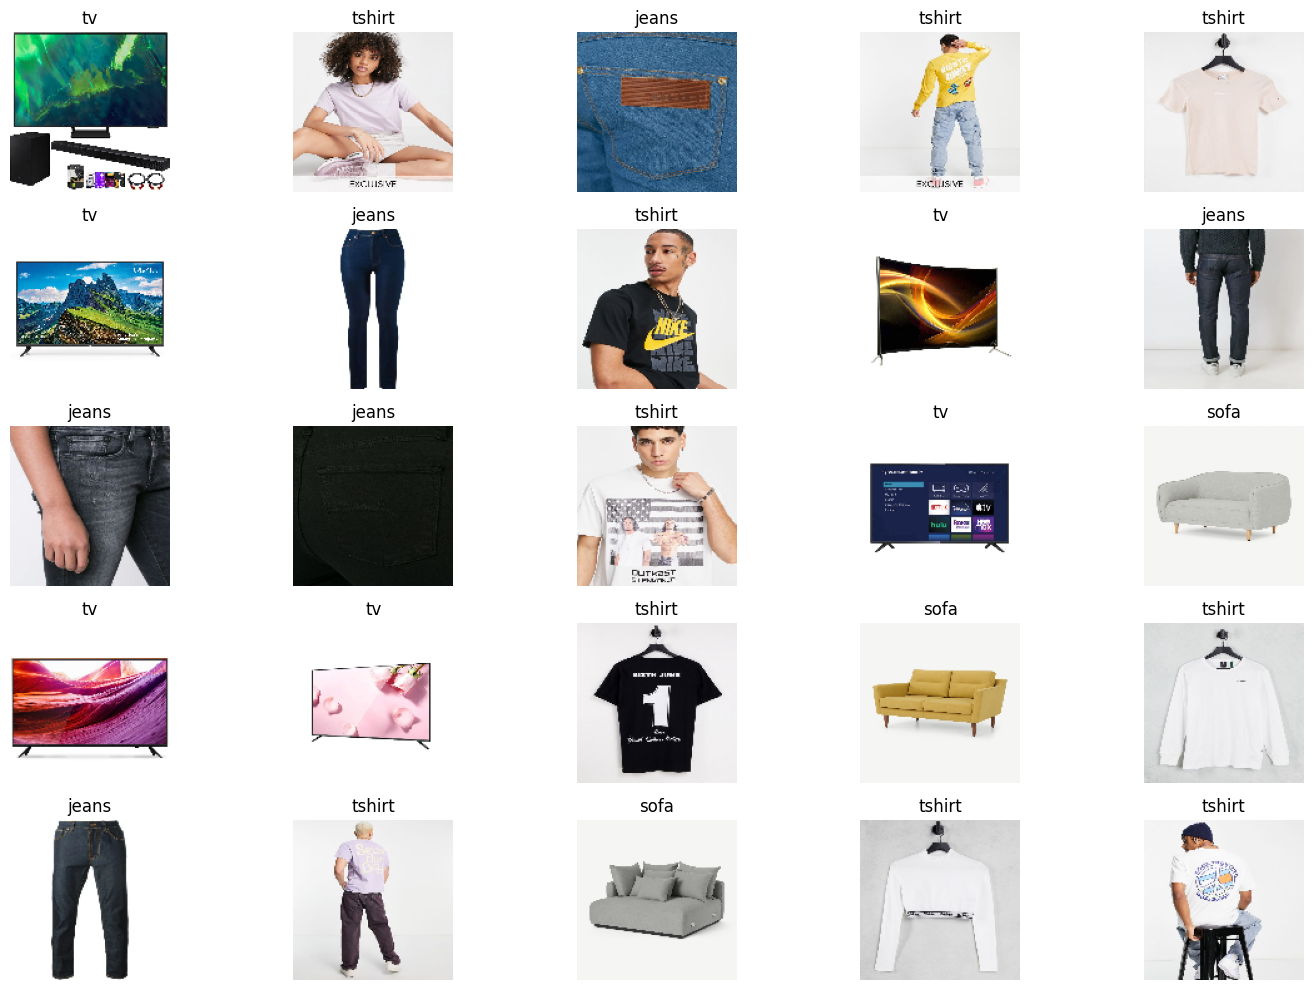

In [344]:


# Función para convertir one-hot encoding a nombre de clase
def one_hot_to_class_name(one_hot, classes):
    return classes[np.argmax(one_hot)]

# Seleccionar algunas imágenes y etiquetas del conjunto de entrenamiento
num_samples = 25  # Número total de imágenes a mostrar
num_rows = 5      # Número de filas en la matriz
num_cols = 5     # Número de columnas en la matriz

# Asegurarse de que el número de imágenes coincida con la matriz
assert num_samples == num_rows * num_cols, "El número de imágenes debe ser igual a filas * columnas"

# Seleccionar aleatoriamente las imágenes
sample_indices = np.random.choice(len(X_train), num_samples, replace=False)
sample_images = X_train[sample_indices]
sample_labels = y_train[sample_indices]

# Mostrar las imágenes en una matriz
plt.figure(figsize=(15, 10))
for i, (img, label) in enumerate(zip(sample_images, sample_labels)):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(img)
    class_name = one_hot_to_class_name(label, classes)  # Convertir one-hot a nombre de clase
    plt.title(class_name)
    plt.axis('off')
plt.tight_layout()  # Ajustar el espaciado entre imágenes
plt.show()

In [345]:
model = Sequential([
    # Primera capa convolucional
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),

    # Segunda capa convolucional
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Tercera capa convolucional
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Aplanar la salida para las capas densas
    Flatten(),

    # Capa densa con dropout para evitar overfitting
    Dense(128, activation='relu'),
    Dropout(0.5),

    # Capa de salida para clasificación multiclase
    Dense(4, activation='softmax')  # 4 clases: jeans, sofa, tshirt, tv
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [346]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_96 (Conv2D)                   │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_95 (MaxPooling2D)      │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_97 (Conv2D)                   │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_96 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_98 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_97 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_25 (Flatten)                 │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_74 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,156 (12.61 MB)

 Trainable params: 3,305,156 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [347]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

In [348]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [349]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)

In [350]:
train_generator = datagen.flow(X_train, y_train, batch_size=32)

In [351]:
history = model.fit(X_train, y_train, batch_size=32,
                    validation_data=(X_val, y_val),
                    epochs=20,
                    callbacks=[early_stop, reduce_lr])

Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 370ms/step - accuracy: 0.3892 - loss: 1.5688 - val_accuracy: 0.8039 - val_loss: 0.5776 - learning_rate: 0.0010
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.8390 - loss: 0.5706 - val_accuracy: 0.8431 - val_loss: 0.4604 - learning_rate: 0.0010
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8609 - loss: 0.3915 - val_accuracy: 0.8824 - val_loss: 0.4515 - learning_rate: 0.0010
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9116 - loss: 0.2796 - val_accuracy: 0.8529 - val_loss: 0.4170 - learning_rate: 0.0010
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9088 - loss: 0.2606 - val_accuracy: 0.9020 - val_loss: 0.3781 - learning_rate: 0.0010
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9267 - loss: 0.1679 - val_accuracy: 0.9118 - val_loss: 0.3255 - learning_rate: 0.0010
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9661 - loss: 0.1017 - val_

In [352]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Pérdida en el conjunto de prueba: {loss}')
print(f'Precisión en el conjunto de prueba: {accuracy}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - accuracy: 0.9308 - loss: 0.1929
Pérdida en el conjunto de prueba: 0.18546076118946075
Precisión en el conjunto de prueba: 0.9416666626930237


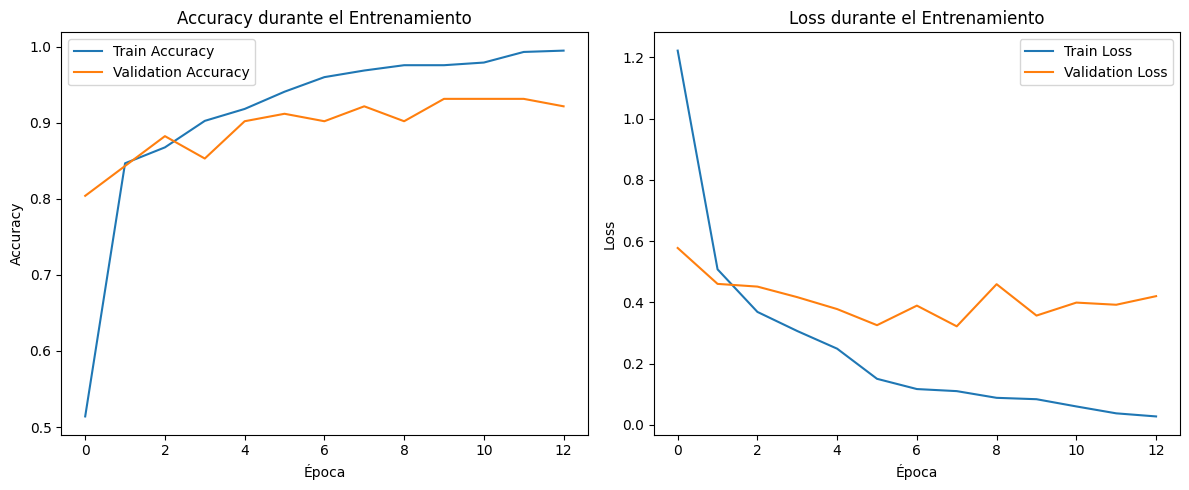

In [353]:
import matplotlib.pyplot as plt

# Supongamos que ya has entrenado el modelo y tienes el objeto `history`
# history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)

# Extraer los valores de accuracy y loss del historial
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Crear una figura con dos subplots
plt.figure(figsize=(12, 5))

# Gráfico de Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()

# Gráfico de Loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

# Mostrar los gráficos
plt.tight_layout()
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step
Classification Report:
              precision    recall  f1-score   support

       jeans       0.96      0.90      0.93        30
        sofa       0.96      1.00      0.98        27
      tshirt       0.87      0.96      0.91        27
          tv       0.97      0.92      0.94        36

    accuracy                           0.94       120
   macro avg       0.94      0.94      0.94       120
weighted avg       0.94      0.94      0.94       120



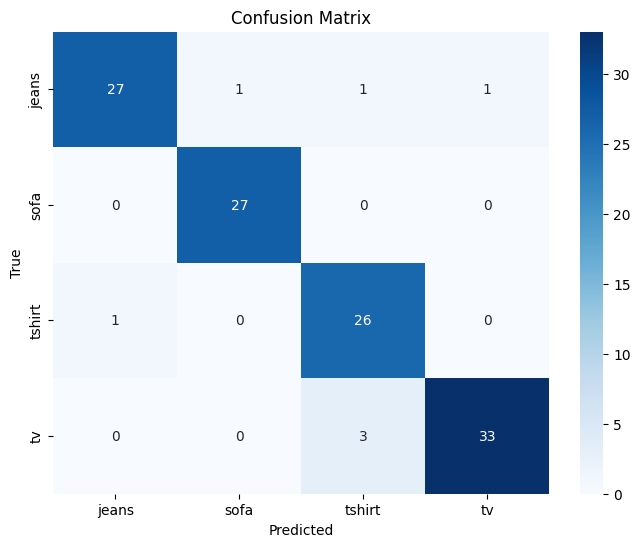

In [354]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Hacer predicciones en el conjunto de prueba
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convertir one-hot a índices de clase
y_true_classes = np.argmax(y_test, axis=1)  # Convertir one-hot a índices de clase

# Mostrar el reporte de clasificación
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=classes))

# Mostrar la matriz de confusión
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [355]:
model.save('modelo_entrenado.h5')

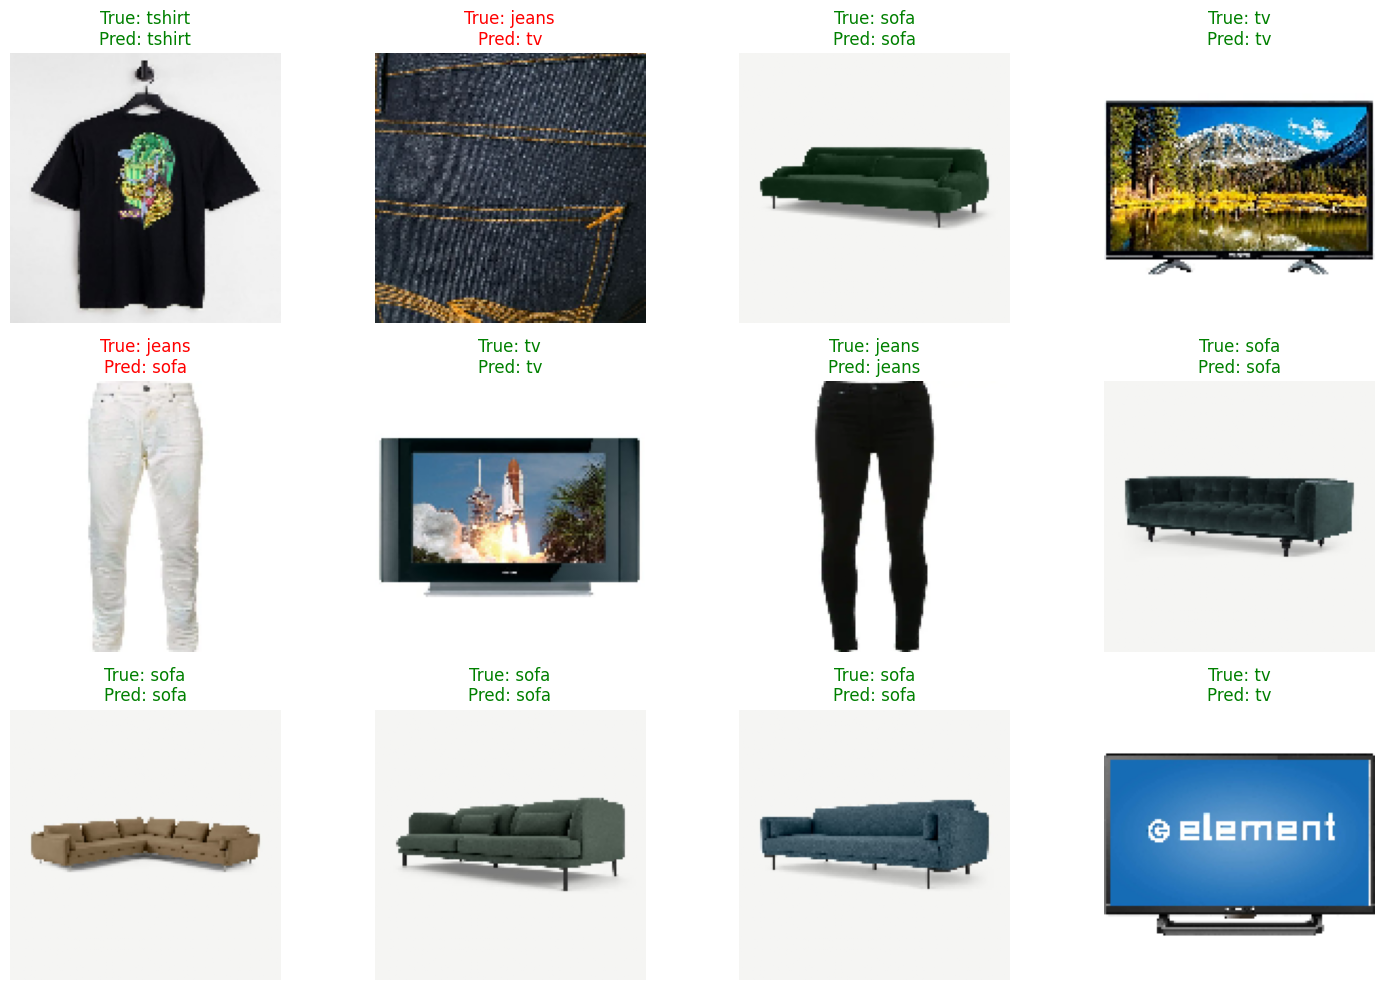

In [356]:
# Seleccionar algunas imágenes del conjunto de prueba
num_samples = 12  # Número de imágenes a mostrar
num_rows = 3      # Número de filas en la matriz
num_cols = 4      # Número de columnas en la matriz

# Seleccionar aleatoriamente las imágenes
sample_indices = np.random.choice(len(X_test), num_samples, replace=False)
sample_images = X_test[sample_indices]
sample_true_labels = y_true_classes[sample_indices]
sample_pred_labels = y_pred_classes[sample_indices]

# Mostrar las imágenes con sus etiquetas reales y predichas
plt.figure(figsize=(15, 10))
for i, (img, true_label, pred_label) in enumerate(zip(sample_images, sample_true_labels, sample_pred_labels)):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(img)
    true_class = classes[true_label]  # Convertir índice a nombre de clase
    pred_class = classes[pred_label]  # Convertir índice a nombre de clase
    plt.title(f'True: {true_class}\nPred: {pred_class}', color='green' if true_label == pred_label else 'red')
    plt.axis('off')
plt.tight_layout()
plt.show()

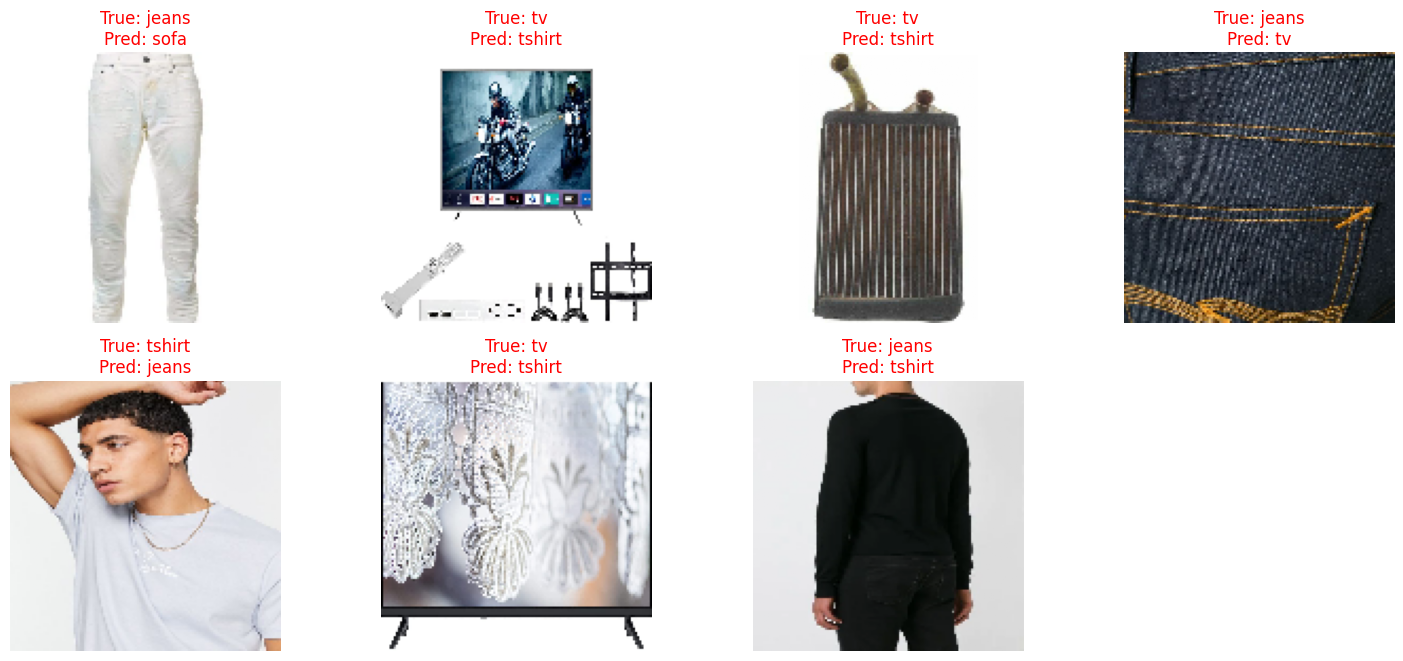

In [357]:
# Encontrar índices de predicciones incorrectas
incorrect_indices = np.where(y_true_classes != y_pred_classes)[0]

# Mostrar algunas predicciones incorrectas
num_samples = min(len(incorrect_indices), 12)  # Mostrar hasta 12 errores
num_rows = 3
num_cols = 4

plt.figure(figsize=(15, 10))
for i, idx in enumerate(incorrect_indices[:num_samples]):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(X_test[idx])
    true_class = classes[y_true_classes[idx]]
    pred_class = classes[y_pred_classes[idx]]
    plt.title(f'True: {true_class}\nPred: {pred_class}', color='red')
    plt.axis('off')
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


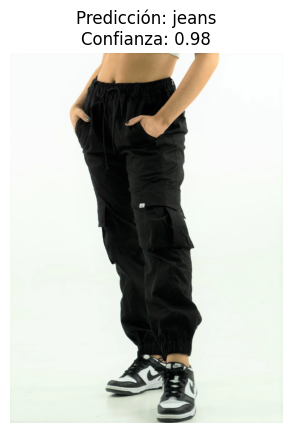

In [358]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Cargar el modelo entrenado (si no lo tienes ya cargado)
# model = tf.keras.models.load_model('ruta/al/modelo_entrenado.h5')

# Ruta de la imagen que quieres probar
image_path = 'pantalon3.png'  # Cambia esto por la ruta de tu imagen

# Cargar y preprocesar la imagen
def load_and_preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)  # Redimensionar la imagen
    img_array = image.img_to_array(img) / 255.0  # Normalizar al rango [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Añadir dimensión del batch
    return img_array

# Cargar y preprocesar la imagen
img_array = load_and_preprocess_image(image_path, img_size)

# Hacer la predicción
prediction = model.predict(img_array)
predicted_class_index = np.argmax(prediction, axis=1)[0]  # Obtener el índice de la clase predicha
predicted_class = classes[predicted_class_index]  # Obtener el nombre de la clase predicha
confidence = np.max(prediction)  # Obtener la confianza de la predicción

# Mostrar la imagen y la predicción
plt.imshow(image.load_img(image_path))
plt.title(f'Predicción: {predicted_class}\nConfianza: {confidence:.2f}')
plt.axis('off')
plt.show()